# Entrega 2

## Ejercicio 1

### a. ¿Que situacion se representa con una variable aleatoria geometrica?

Usamos una variable aleatoria geométrica para modelar el número de intentos necesarios hasta llegar al primer éxito en ensayos de Bernoulli independientes y con probabilidad constante de éxito $\theta$

Algunos ejemplos son:
- Lanzamientos de una moneda
- Control de Calidad
- y muchos mas

### b. Derivar la distribucion posterior para $\theta$ suponiendo que se observó Y = y. Identificar la distribución encontrada y sus parámetros.

Sabemos:
1. Prior ∼ Beta(a, b)
2. Likelihood: $P(Y = y∣\theta) = \theta(1 - \theta)^{y-1}$
3. Posterior: Multiplicamos el Prior por la Likelihood y normalizamos:
    - $\theta ∣ Y = y ∼ Beta(a + 1, b + y - 1)$

### c. ¿El modelo Beta es un prior conjugado de la Geométrica?

Si, pues el Prior y el Posterior pertenecen al mismo tipo de distribuciones (Beta)

---

Bis: Ejemplo (para mi) para fijar mejor las ideas:

Supongamos un juego de donde se debe lanzar un dado y se gana al sacar un "6". Se quiere estimar la probabilidad $\theta$ de ganar en un solo lanzamiento. 

Supongo que es dificil sacar ese "6", pero no estoy seguro y quiero actualizar mi creencia luego de cada lanzamiento.

Entonces:
- Variable aleatoria Y: Numero de lanzamientos hasta sacar el "6".
- Distr Geometrica: $P(Y = y∣\theta) = \theta(1 - \theta)^{y-1}$
- Prior Beta: Empezamos de forma pesimista sobre sacar un "6". a = 2, b = 10.

Observacion:

Imagino que juego el juego, y el primer "6" aparece en mi 5to lanzamiento. Y = 5.

Actualizacion:

- Likelihood: Y = 5 con lo que:  $\theta (1 - \theta)^{4}$
- Posterior: Posterior $\alpha$ Prior * Likelihood = Beta(2, 10) * $\theta (1 - \theta)^{4}$
        - Es decir: Post $\alpha$ $\theta^{2 + 1}(1 - \theta)^{10 + 4 - 1}$ = $\theta^{3}(1 - \theta)^{13}$

Esto significa que el Post tambien es Beta. Pues Post = Beta(3, 13)

---

## Ejercicio 2

Elijo como modelo de Regresion Lineal el precio de la comida y la propina dejada.

Obtenemos nuestros datos:

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt


from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño

In [50]:
datos = sns.load_dataset('tips')

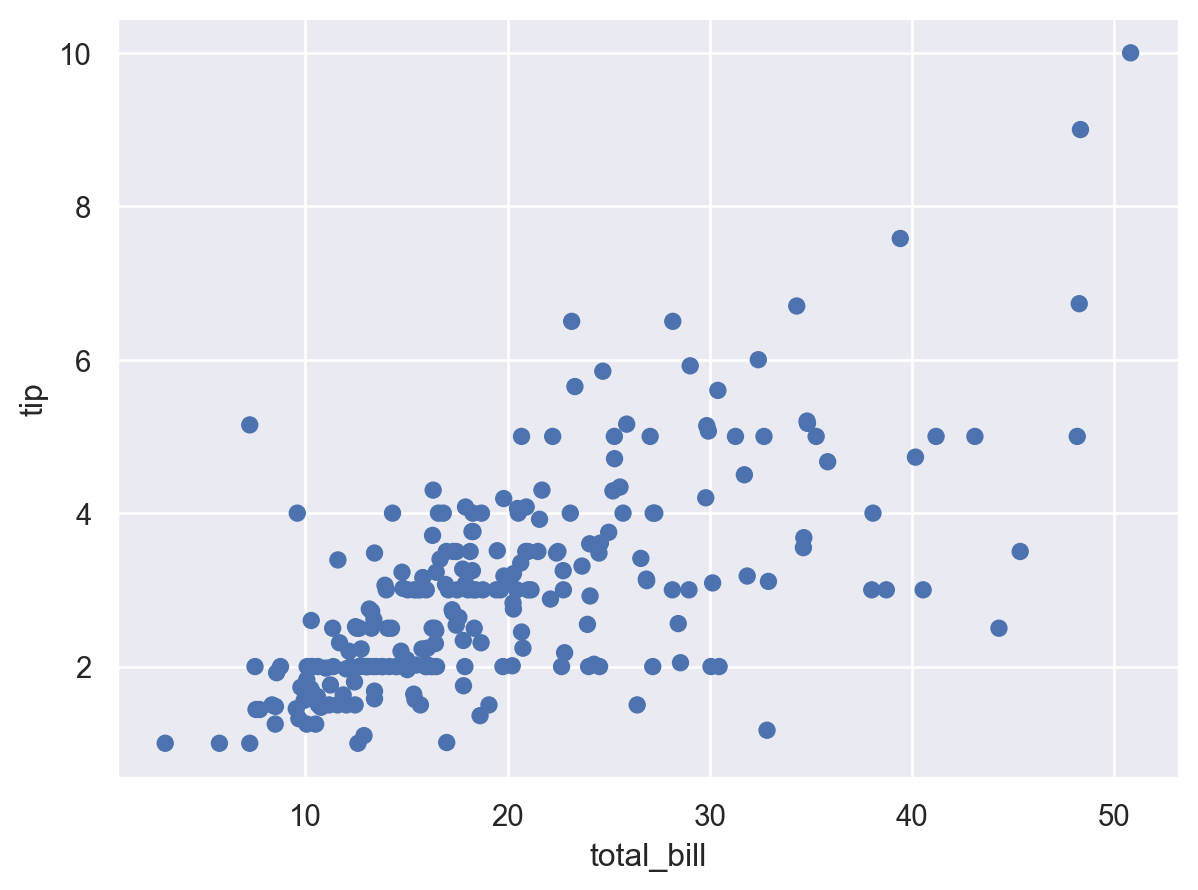

In [51]:
(
    so.Plot(data=datos, x='total_bill', y='tip')
    .add(so.Dot())
)


### a. Proponer priors para $\beta_0$, $\beta_1$ y $\sigma $

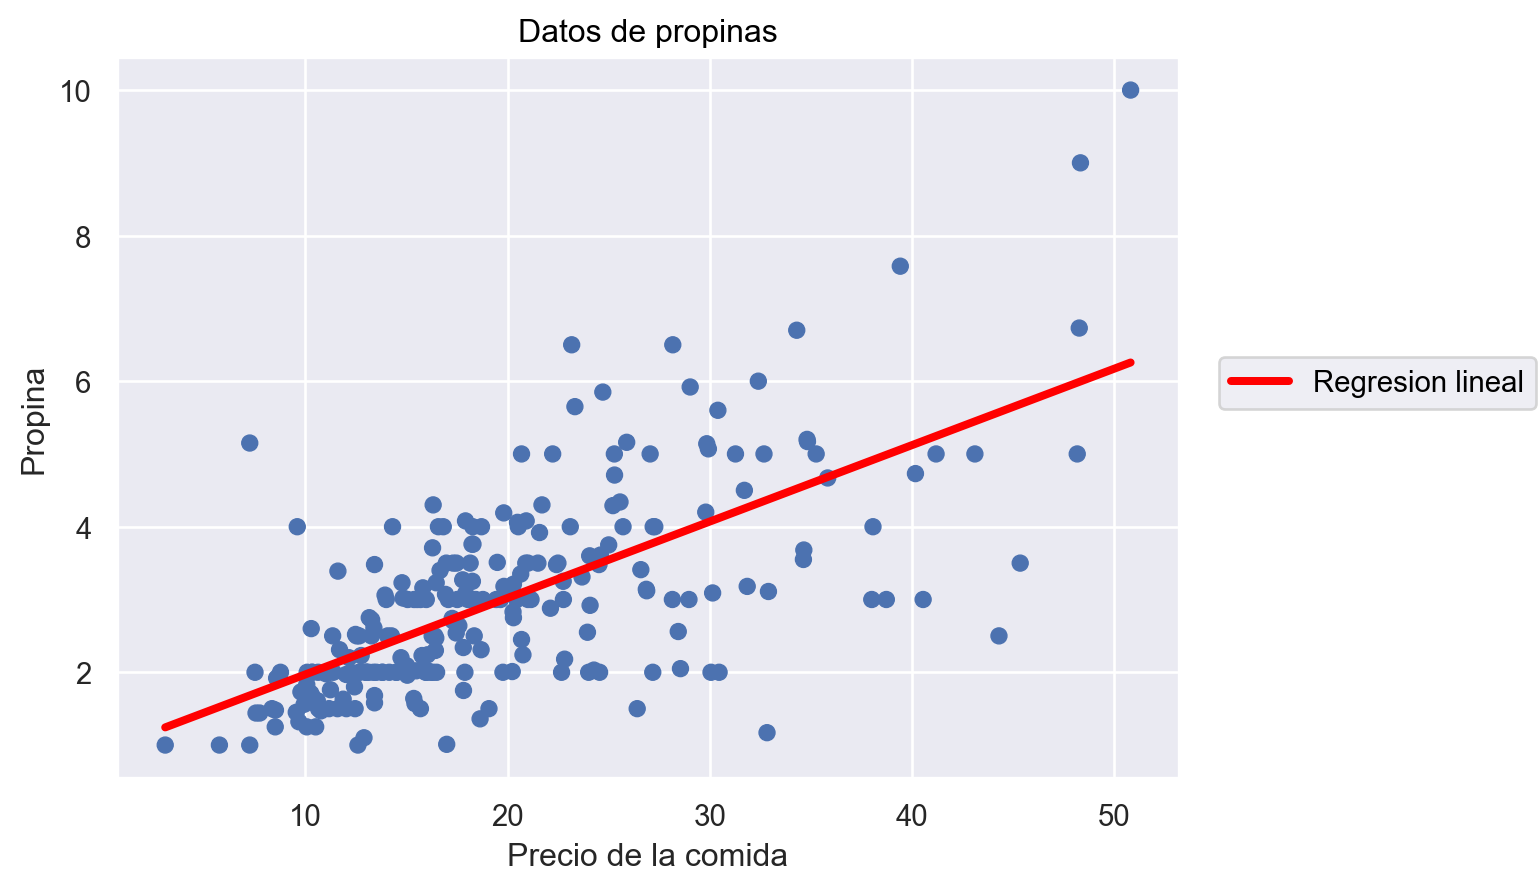

In [52]:
(
    so.Plot(data=datos, x='total_bill', y='tip')
    .add(so.Dot())
    .add(so.Line(color='red', linewidth=3), so.PolyFit(1), label='Regresion lineal')  
    .label(title='Datos de propinas', x='Precio de la comida', y='Propina')    
)


Calculo $\beta_0$ y $\beta_1$

In [53]:
X = datos[["total_bill"]]
y = datos[['tip']]

modelo = linear_model.LinearRegression()    
modelo.fit(X, y)   
beta_1 = modelo.coef_   
beta_0 = modelo.intercept_ 


beta_1 = modelo.coef_.item()
beta_0 = modelo.intercept_.item()
print('Beta_1: ', beta_1)
print('Beta_0: ', beta_0)

import scipy.stats as stats

# Parámetros de la distribución Inversa-Gamma
alpha = 2
beta = 2

# Generar una muestra de la distribución prior para sigma
#prior_sigma = stats.invgamma.rvs(alpha, scale=beta, size=1000)

# Imprimir algunos valores de la muestra prior para sigma
#print('Prior para sigma:')
#print(prior_sigma[:10])


Beta_1:  0.10502451738435337
Beta_0:  0.9202696135546731


Obtenemos que $y = \beta_0 + \beta_1 X + \epsilon $

Donde $\epsilon$ es el residuo.

Ajustamos el modelo para poder obtener los $y_{predichos}$ y asi poder calcular $\sigma$

In [54]:
y_pred = modelo.predict(X)

Calculo $\sigma$

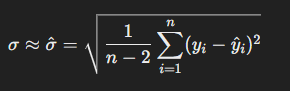

In [55]:
residuos = y.values.flatten() - y_pred.flatten()
sigma = np.sqrt((sum(residuos) / len(residuos))**2 / (len(residuos) + 2))
sigma

np.float64(3.330387271046276e-17)

Como $\sigma$ nos dio casi 0, significa que los datos ajustan muy bien el modelo.

### b. Implementar MCMC y generar 5mil samples del posterior sin descontar el tramo inicial de la cadena (burn = 0) 

#### 1. Definir Likelihood

Definimos la funcion de Likelihood
- $L(y \mid \mu, \sigma) = - \frac{n}{2}log(2\pi \sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^2  $

Donde:
1. n = numero de observaciones
2. $\hat{y}_{i}$ = valor predicho de $y_i$

In [61]:
# Definir la función de Likelihood
def log_likelihood(mu, sigma, X, y):
    n = len(y)
    y_pred = mu[0] + mu[1] * X
    residuals = y - y_pred
    return -0.5 * n * np.log(2 * np.pi * sigma**2) - 0.5 * np.sum(residuals**2) / sigma**2


2. Definir los Priors

1. Elegimos un prior no informativo para $\mu$
    - Esto implica que no tenemos conocimiento previo sobre los valores de $\mu$. No afectamos su verosimilitud.

2. Elegimos un prior exponencial para $\sigma$. 
    - Esto implica que creemos que los valores más pequeños de $\sigma$ son màs probables.
    - $p(\sigma) ∼ exp(-\lambda \sigma)$
    Donde $\lambda$ controla la "fuerza" de este prior. La funcion devuelve el log de este prior.

In [ ]:
# Definir los priors
def prior_mu(mu):
    # Prior no informativo para mu (coeficientes)
    return 0  # Prior constante (no informativo)

def prior_sigma(sigma, lam=1):
    # Prior exponencial para sigma
    if sigma > 0:
        return -lam * sigma  # log de la exponencial
    else:
        return -np.inf  # Penalizar si sigma es <= 0

3. Propuesta para nuevos valores de $\mu$ y $\sigma$

En cada paso del algoritmo MCMC, proponemos nuevos valores para $\mu$ y $\sigma$.

In [62]:
def propuesta_mu(mu):
    return np.random.normal(mu, 0.1, size=2)  # Propuesta normal

def propuesta_sigma(sigma):
    return np.abs(np.random.normal(sigma, 0.05))  # Propuesta normal positiva

4. MCMC Metropolis-Hastings

In [63]:
# MCMC Metropolis-Hastings
def metropolis_hastings(X, y, iteraciones=5000, sigma_inicial=1, mu_inicial=(0, 0)):
    mu_actual = np.array(mu_inicial)
    sigma_actual = sigma_inicial

    muestras_mu = [mu_actual]
    muestras_sigma = [sigma_actual]
    
    for i in range(iteraciones):
        # Proponer nuevos valores para mu y sigma
        mu_propuesta = propuesta_mu(mu_actual)
        sigma_propuesta = propuesta_sigma(sigma_actual)
        
        # Calcular la probabilidad de aceptación
        log_likelihood_actual = log_likelihood(mu_actual, sigma_actual, X, y)
        log_likelihood_propuesta = log_likelihood(mu_propuesta, sigma_propuesta, X, y)
        
        log_prior_actual = prior_mu(mu_actual) + prior_sigma(sigma_actual)
        log_prior_propuesta = prior_mu(mu_propuesta) + prior_sigma(sigma_propuesta)
        
        log_posterior_actual = log_likelihood_actual + log_prior_actual
        log_posterior_propuesta = log_likelihood_propuesta + log_prior_propuesta
        
        # Ratio de aceptación
        alpha = np.exp(log_posterior_propuesta - log_posterior_actual)
        alpha = min(1, alpha)
        
        # Aceptar o rechazar la propuesta
        if np.random.rand() < alpha:
            mu_actual = mu_propuesta
            sigma_actual = sigma_propuesta
        
        # Guardar las muestras
        muestras_mu.append(mu_actual)
        muestras_sigma.append(sigma_actual)
    
    return np.array(muestras_mu), np.array(muestras_sigma)

# Ejecutar el MCMC
muestras_mu, muestras_sigma = metropolis_hastings(X.values.flatten(), y.values.flatten())

# Extraer las últimas muestras para análisis
mu_final = muestras_mu[-1]
sigma_final = muestras_sigma[-1]

print("Mu (Beta_0, Beta_1):", mu_final)
print("Sigma estimado:", sigma_final)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_11556\382747061.py:25: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(log_posterior_propuesta - log_posterior_actual)


Mu (Beta_0, Beta_1): [1.09699533 0.0978951 ]
Sigma estimado: 0.9509204415111251


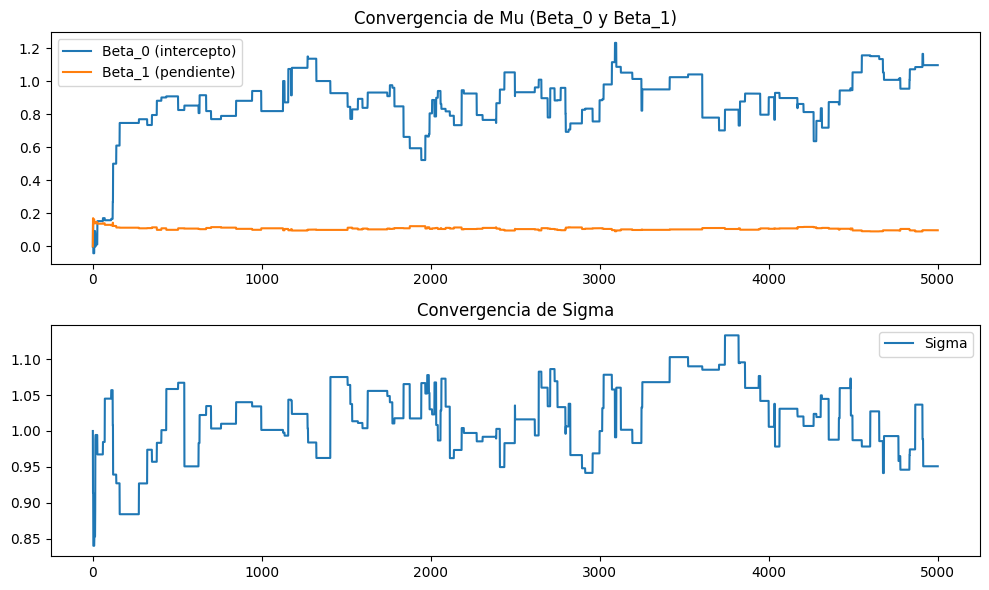

In [64]:
# Graficar la convergencia de mu y sigma
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

axs[0].plot(muestras_mu[:, 0], label='Beta_0 (intercepto)')
axs[0].plot(muestras_mu[:, 1], label='Beta_1 (pendiente)')
axs[0].set_title('Convergencia de Mu (Beta_0 y Beta_1)')
axs[0].legend()

axs[1].plot(muestras_sigma, label='Sigma')
axs[1].set_title('Convergencia de Sigma')
axs[1].legend()

plt.tight_layout()
plt.show()
